In [113]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

!pip install -U emojis
import emojis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data] Downloading package punkt to /home/lluneta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [114]:

df = pd.read_json('data/dataset_en_train.json')

In [115]:
df

,id,text,category,annotations,spacy_tokens
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...
...,...,...,...,...,...
3995,4829,Police in Australia are warning that unvaccina...,CRITICAL,"[{'span_text': 'Police in Australia', 'categor...",WyJQb2xpY2UiLCAiaW4iLCAiQXVzdHJhbGlhIiwgImFyZS...
3996,10899,I personally do n’t believe Putin would set of...,CONSPIRACY,"[{'span_text': 'Deep State', 'category': 'AGEN...",WyJJIiwgInBlcnNvbmFsbHkiLCAiZG8iLCAiblx1MjAxOX...
3997,10637,Pfizer lied . We know that . There 's no doubt...,CRITICAL,"[{'span_text': 'Pfizer', 'category': 'AGENT', ...",WyJQZml6ZXIiLCAibGllZCIsICIuIiwgIldlIiwgImtub3...
3998,11338,""" It is utterly bizarre and inexplicable - Dr....",CRITICAL,"[{'span_text': 'Dr. John Campbell', 'category'...",WyJcIiIsICJJdCIsICJpcyIsICJ1dHRlcmx5IiwgImJpem...


## Features

In [124]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

nlp = spacy.load("en_core_web_sm")
def proper_nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper nouns
    return pos.count('PROPN')

def punc_count(text):
    return len([w for w in text if w in string.punctuation])

#def sentiment_score(text):
    #doc = nlp(text)
    #sentiment_score = doc.sentiment
    #return sentiment_score
    
    #sentiment =  nlp.sentiment_analyzer(text)
    #return sentiment.score

    
# ---> 1 means positive
analyzer = SentimentIntensityAnalyzer()
def sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

    
def stop_word_count(text):
    word_tokens = word_tokenize(text) 
    stop_word = len([w for w in word_tokens if w in stopwords.words('english')])
    return stop_word

def emoji_count(text):
    return emojis.count(text)

print(emoji_count('hellooo.😄 🐍'))
print(stop_word_count('an apple a day keeps the doctor away.'))
print(sentiment_score('I am so happy !'))

2
3
1


/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


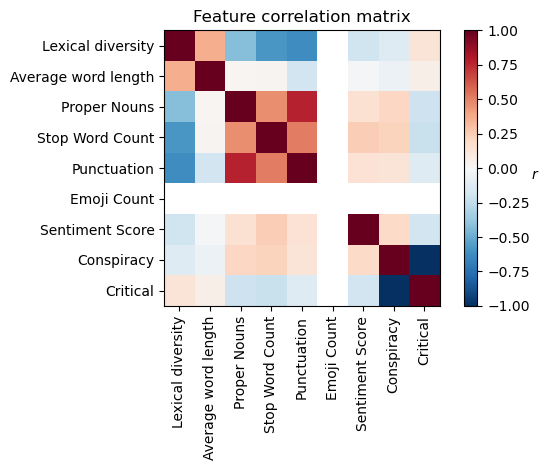

In [125]:
ax = plt.axes()
feature_names = ['Lexical diversity', 'Average word length', 'Proper Nouns', 'Stop Word Count', 'Punctuation', 'Emoji Count','Sentiment Score', 'Conspiracy', 'Critical', ]
df['lexical_div'] = df['text'].apply(lexical_diversity)
df['avg_word_len'] = df['text'].apply(avg_word_length)
df['conspiracy'] = df['category'].apply(lambda x : float(x=='CONSPIRACY'))
df['critical'] = df['category'].apply(lambda x : float(x=='CRITICAL'))
df['proper_nouns'] = df['text'].apply(proper_nouns)
df['punc_count'] = df['text'].apply(punc_count)
df['sentiment_score'] = df['text'].apply(sentiment_score)
df['stop_word_count'] = df['text'].apply(stop_word_count)
df['emoji_count'] = df['text'].apply(emoji_count)
im = ax.imshow(np.corrcoef(df[['lexical_div', 'avg_word_len', 'proper_nouns', 'stop_word_count','punc_count','emoji_count','sentiment_score', 'conspiracy', 'critical']].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(feature_names))))
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticks(list(range(len(feature_names))))
ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()